<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/hmm_casino_em.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fit a discrete HMM to the casino dataset using EM.

In [1]:
!pip install flax

     |████████████████████████████████| 183 kB 7.1 MB/s 
     |████████████████████████████████| 118 kB 12.1 MB/s 
     |████████████████████████████████| 57 kB 4.9 MB/s 


In [2]:
!git clone https://github.com/probml/pyprobml /pyprobml &> /dev/null
%cd -q /pyprobml/scripts

In [3]:
file = 'hmm_discrete_lib.py' 
!touch $file # create empty file if does not already exist
from google.colab import files
files.view(file) # open editor

<IPython.core.display.Javascript object>

In [4]:

import jax.numpy as jnp
from jax.random import split, PRNGKey, randint

import numpy as np

from hmm_discrete_lib import HMMNumpy, HMMJax, hmm_sample_jax
from hmm_discrete_lib import hmm_plot_graphviz

from hmm_discrete_em_lib import init_random_params_jax
from hmm_discrete_em_lib import hmm_em_numpy, hmm_em_jax

import hmm_utils

import time

import graphviz 
from graphviz import Digraph


# Generate data from the true model

In [9]:
A = jnp.array([
    [0.95, 0.05],
    [0.10, 0.90]
])

# observation matrix
B = jnp.array([
    [1/6, 1/6, 1/6, 1/6, 1/6, 1/6], # fair die
    [1/10, 1/10, 1/10, 1/10, 1/10, 5/10] # loaded die
])

pi = jnp.array([1, 1]) / 2

seed = 42 #100
rng_key = PRNGKey(seed)
rng_key, rng_sample, rng_batch, rng_init = split(rng_key, 4)

casino = HMMJax(A, B, pi)

n_obs_seq, batch_size, max_len = 5, 5, 3000

observations, lens = hmm_utils.hmm_sample_n(casino,
                                            hmm_sample_jax,
                                            n_obs_seq, max_len,
                                            rng_sample)
observations, lens = hmm_utils.pad_sequences(observations, lens)


In [10]:
print(observations.shape)

(5, 3000)


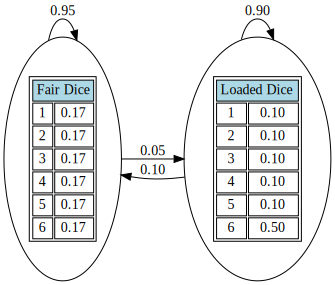

In [11]:

state_names, obs_names = ['Fair Dice', 'Loaded Dice'], [str(i+1) for i in range(B.shape[1])]

dot = hmm_plot_graphviz(casino, '../figures/hmm_casino_true', state_names, obs_names)
dot

# Fit model

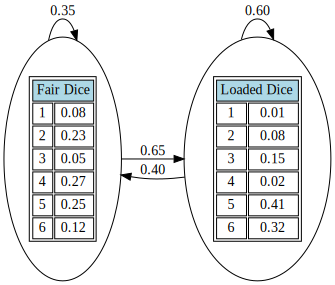

In [12]:
# Initialize model randomly

n_hidden, n_obs = B.shape
params_jax = init_random_params_jax([n_hidden, n_obs], rng_key=rng_init)

dot = hmm_plot_graphviz(params_jax, '../figures/hmm_casino_init', state_names, obs_names)
dot





In [13]:


num_epochs = 20
params_jax, neg_ll_jax = hmm_em_jax(observations,
                                    lens,
                                    num_epochs=num_epochs,
                                    init_params=params_jax)

# Plot results

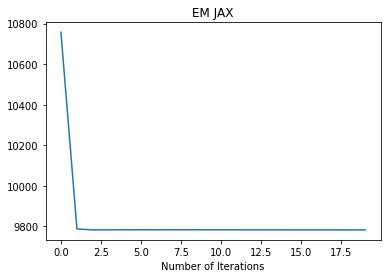

In [14]:
hmm_utils.plot_loss_curve(neg_ll_jax, "EM JAX")


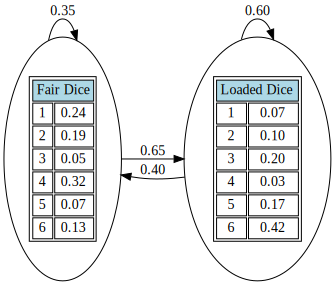

In [15]:


dot = hmm_plot_graphviz(params_jax, '../figures/hmm_casino_em', state_names, obs_names)
dot